# Titanic: Machine Learning From Disaster

## The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Description:
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone on board, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Acknowledgements:
This dataset has been referred from Kaggle: https://www.kaggle.com/c/titanic/data.

### Objective:
Understand the Dataset & cleanup (if required).
Build a strong classification model to predict whether the passenger survives or not.
Also fine-tune the hyperparameters & compare the evaluation metrics of various classification algorithms.

## 1. Import libraries and read all files 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 

In [8]:
from IPython.display import Markdown as md
from IPython.core.display import HTML
import itertools
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Read files
gender_submission = pd.read_csv("../data/input/gender_submission.csv")
# Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, the “ground truth”.
train = pd.read_csv("../data/input/train.csv")
# The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.
test = pd.read_csv("../data/input/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 2. Data Exploration

---------------------- 
| categorical | numerical | 
|--- |--- | 
| Survived | boolean | 
| Age | continuous | 
| Pclass | ordinal | 
| SibSp | discrete | 
| Name | nominal |
| Parch | discrete |
| Sex | boolean |
| Fare | continuous | 
| Ticket | nominal |
| Cabin | nominal |
| Embarked | nominal |
---



### Ploting Categorical Features

<Axes: xlabel='Embarked'>

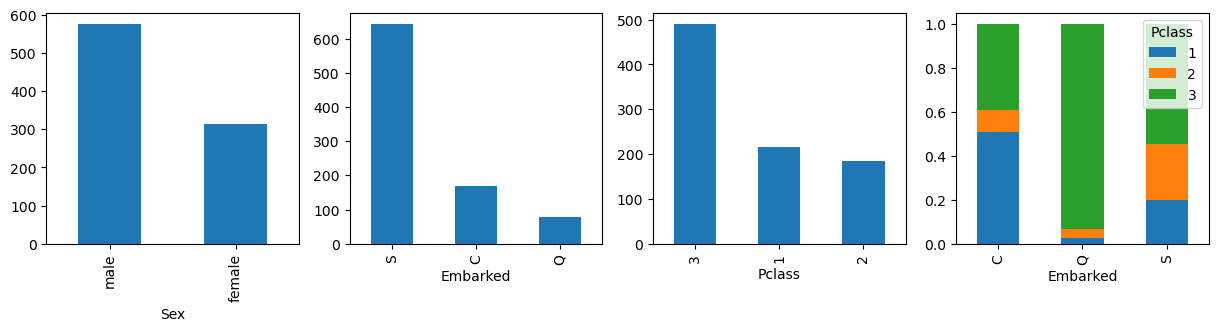

In [5]:
fig, ax = plt.subplots(1,4, figsize=(15,3))

train.Sex.value_counts().plot(kind='bar', ax=ax[0])
train.Embarked.value_counts().plot(kind='bar', ax=ax[1])
train.Pclass.value_counts().plot(kind='bar', ax=ax[2])

df_plot = train.groupby(['Pclass', 'Embarked']).size().reset_index().pivot(columns='Pclass', index='Embarked', values=0)
df_plot.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax[3])

### Ploting Numerical Features

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

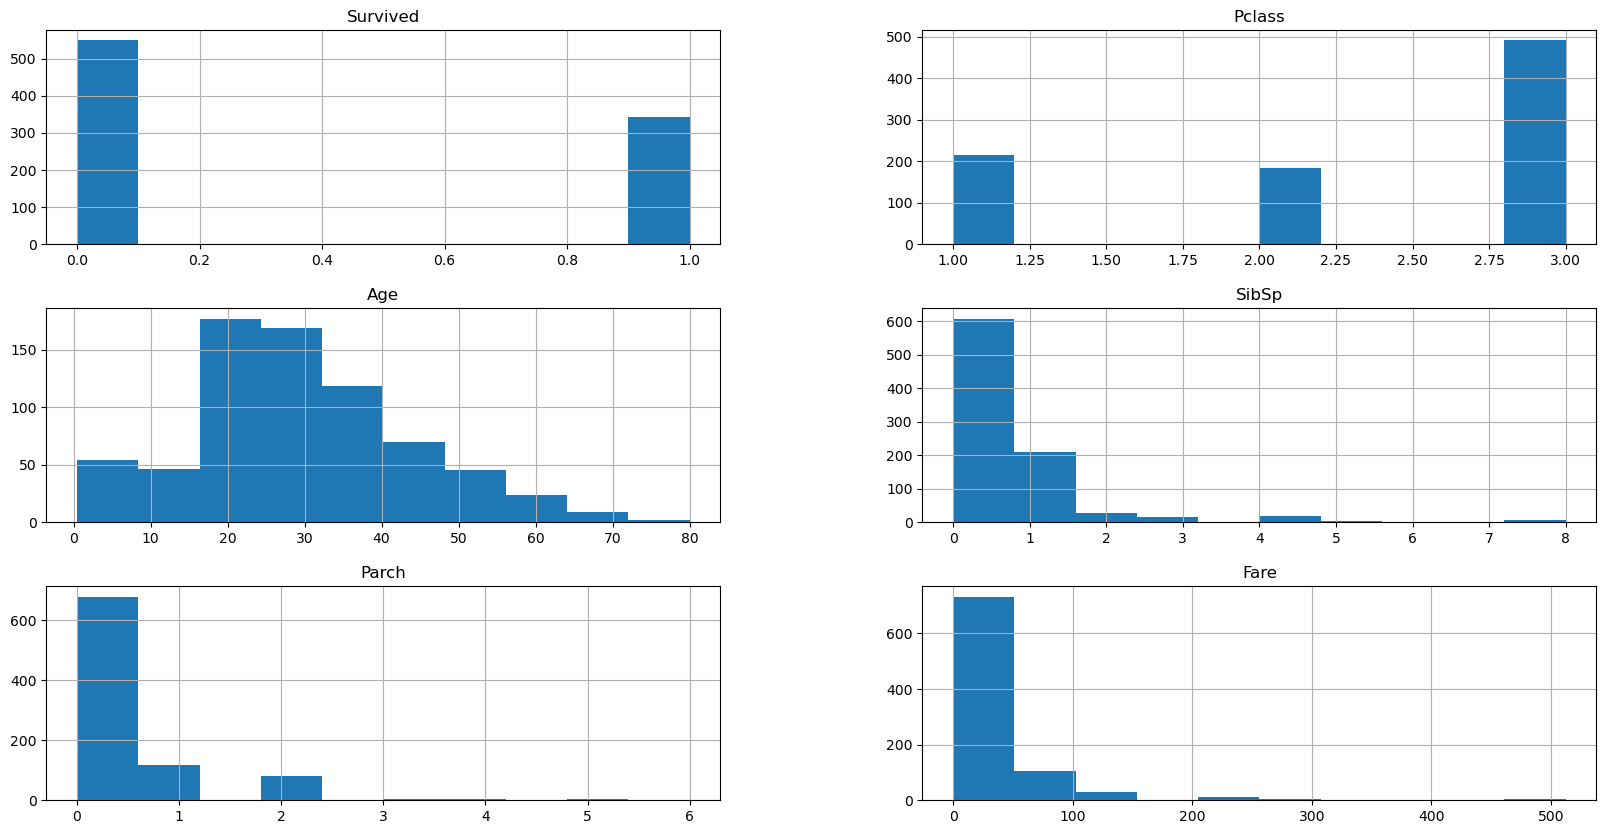

In [6]:
train.drop(['PassengerId'], axis=1).hist(figsize=(20,10))

## 3. Data Transformation

Survived - True and False

Pcclass - boolean

- Pcclass_1
- Pcclass_2
- Pcclass_3

Name - removed for now

Ticket - removed for now

Cabin - removed for now

Embarked - boolean

- Embarked_C
- Embarked_Q
- Embarked_S

In [9]:
pclass_dummies = pd.get_dummies(train.Pclass, prefix = 'Pcclass')
embarked_dummies = pd.get_dummies(train.Embarked, prefix = 'Embarked')
sex_dummies = pd.get_dummies(train.Sex, prefix = 'Sex')

train_y = train['Survived']

titanic_train = train.drop(['PassengerId','Name','Ticket','Cabin','Pclass','Embarked','Sex','Survived'], axis=1)
titanic_train["Age"].fillna(train["Age"].mean(), inplace = True)
titanic_train["Fare"].fillna(train["Fare"].mean(), inplace = True)

titanic_train = pd.concat([titanic_train,pclass_dummies,embarked_dummies,sex_dummies], axis=1)
titanic_train.head()

,Age,SibSp,Parch,Fare,Pcclass_1,Pcclass_2,Pcclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,22.0,1,0,7.2500,False,False,True,False,False,True,False,True
1,38.0,1,0,71.2833,True,False,False,True,False,False,True,False
2,26.0,0,0,7.9250,False,False,True,False,False,True,True,False
3,35.0,1,0,53.1000,True,False,False,False,False,True,True,False
4,35.0,0,0,8.0500,False,False,True,False,False,True,False,True


In [10]:
# check if there are nulls
len(titanic_train[titanic_train.isna().any(axis=1)])

0

## 4. Train a Logistic Regression Model

In [11]:
reg = LogisticRegression().fit(titanic_train, train_y)
reg.score(titanic_train, train_y)

C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8058361391694725

## 5. Do the predictions for the Test Set

In [12]:
pclass_dummies = pd.get_dummies(test.Pclass, prefix = 'Pcclass')
embarked_dummies = pd.get_dummies(test.Embarked, prefix = 'Embarked')
sex_dummies = pd.get_dummies(test.Sex, prefix = 'Sex')

titanic_test = test.drop(['PassengerId','Name','Ticket','Cabin','Pclass','Embarked','Sex'], axis=1)
titanic_test["Age"].fillna(train["Age"].mean(), inplace = True)
titanic_test["Fare"].fillna(train["Fare"].mean(), inplace = True)

titanic_test = pd.concat([titanic_test,pclass_dummies,embarked_dummies,sex_dummies], axis=1)
titanic_test

,Age,SibSp,Parch,Fare,Pcclass_1,Pcclass_2,Pcclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,34.500000,0,0,7.8292,False,False,True,False,True,False,False,True
1,47.000000,1,0,7.0000,False,False,True,False,False,True,True,False
2,62.000000,0,0,9.6875,False,True,False,False,True,False,False,True
3,27.000000,0,0,8.6625,False,False,True,False,False,True,False,True
4,22.000000,1,1,12.2875,False,False,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
413,29.699118,0,0,8.0500,False,False,True,False,False,True,False,True
414,39.000000,0,0,108.9000,True,False,False,True,False,False,True,False
415,38.500000,0,0,7.2500,False,False,True,False,False,True,False,True
416,29.699118,0,0,8.0500,False,False,True,False,False,True,False,True


In [13]:
# Check for Nulls
titanic_test[titanic_test.isna().any(axis=1)]

,Age,SibSp,Parch,Fare,Pcclass_1,Pcclass_2,Pcclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male


In [14]:
pred = reg.predict(titanic_test)

my_submission = test[['PassengerId']]
my_submission['Survived'] = pred
my_submission.head()

C:\Users\graci.DESKTOP-I7T8UK6\AppData\Local\Temp\ipykernel_12884\257086778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_submission['Survived'] = pred


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


## 6. Saving the results

In [15]:
my_submission.to_csv('../data/output/my_submission_LR.csv', index=False)